## 학번: 20202670
## 이름: 하서경

## B. 프로젝트에 사용할 데이터를 수집하고, 그래프, 표 등을 이용하여 설명합니다. (100점)
1. 데이터의 출처, 수집방법 등을 간단히 설명합니다.<br>
여러 주식 투자책을 읽어본 결과, 주가가 빠르게 상승하며 미래에 높은 이익을 기대할 수 있는 성장주에 투자함이 저의 투자성향에 부합함을 깨달았습니다. 성장주를 판별할 수 있는 매출 성장률, 순이익 성장률, EPS 성장률 지표를 구해보고자 합니다. 그 과정은 아래와 같습니다.
- 한국의 기업 공시 정보와 금융 데이터를 제공하는 DART에서 `기업 종목 코드`와 <br>기업별 `단일회사 전체 재무제표 개발가이드`의 손익계산서 데이터를 부른다.
- 손익계산서 중 매출, 순이익, EPS를 추출한 뒤 $Growth = \frac{D_{t} - D_{t-1}}{D_{t-1}} \times 100$으로 각각의 성장률을 구한다.
- 표준편차로 각 지표의 변동성과 타 기업의 성장률간 비교를 수행한다.
  

2. 데이터를 수집하고, 표, 그래프 등으로 내용을 보입니다.

## Import

In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import requests
from bs4 import BeautifulSoup
import json
from pandas import json_normalize
import zipfile
from io import BytesIO
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
# ignore warnings
import warnings ; warnings.filterwarnings('ignore')

## Read Data

- 기업 종목 코드

In [ ]:
# 전체 기업 종목코드를 불러온다.
key = '3510098a70675da8c7a834ab9a8df850762900a0'
url = f'https://opendart.fss.or.kr/api/corpCode.xml?crtfc_key={key}'
res = requests.get(url)
z = zipfile.ZipFile(BytesIO(res.content))
data = z.read('CORPCODE.xml').decode('utf-8')

In [3]:
# Parse the XML data
root = ET.fromstring(data)

In [4]:
# Get data per elements
corporation = []

for i in root.findall('list'):
    corporation.append([i.find(x).text for x in ['corp_code', 'corp_name', 'stock_code']])

# Make DataFrame and Save
# 기업명, 기업코드, 주식코드
corporation = pd.DataFrame(corporation, columns = ['corp_code', 'corp_name', 'stock_code'])
corporation.drop(corporation.query('stock_code==" "').index, inplace=True)

In [5]:
print('DART 내 기업수:', corporation.shape[0])

DART 내 기업수: 3653


- 기업별 손익계산서의 매출, 순이익, EPS 추출하기 

In [6]:
def ISCorporate(CODE, Y, R):
    url = "https://opendart.fss.or.kr/api/fnlttSinglAcntAll.json"
    res = requests.get(url, params={'crtfc_key': key, 'corp_code': CODE, 'bsns_year': Y, 'reprt_code': R, 'fs_div': 'OFS'},
                       verify=False)
    data = json.loads(res.text)
    if data['status'] != '000':
        return pd.DataFrame()
    else:
        IS = json_normalize(data['list']).query('account_id in ["ifrs-full_Revenue","ifrs-full_ProfitLoss","ifrs-full_BasicEarningsLossPerShare"]')\
             [['corp_code', 'bsns_year', 'reprt_code', 'account_id', 'thstrm_amount']]
        # 데이터 전처리
        IS['monday'] = IS['reprt_code'].map({'11011':'1231','11012':'0630','11013':'0331','11014':'0930'})
        IS['date'] = pd.to_datetime(IS['bsns_year']+IS['monday'], format='%Y%m%d', errors='coerce')
        IS['thstrm_amount'] = IS['thstrm_amount'].str.replace(',', '').astype(float)/1000000000000
    return pd.pivot_table(IS, index=['date','corp_code'], columns='account_id', values='thstrm_amount')

In [7]:
# 2015년부터 데이터를 제공해 2015년 이후 기업별 기간, 보고서의 데이터를 추출한다.
data = pd.DataFrame()

for code in tqdm(corporation['corp_code']):
    try:
        ease = pd.concat([ISCorporate(code, y, r) for y in range(2015,2023) for r in [11013, 11012, 11014, 11011]])
        data = pd.concat([data, ease])
    except:
        pass

100%|████████████████████████████████████████████████████████████████████████████| 3653/3653 [4:47:24<00:00,  4.72s/it]


In [8]:
display(data)

,account_id,ifrs-full_BasicEarningsLossPerShare,ifrs-full_ProfitLoss,ifrs-full_Revenue
date,corp_code,,,
2022-06-30,00351092,3.580000e-10,0.006520,0.079238
2022-09-30,00351092,1.880000e-10,0.002616,0.089141
2022-12-31,00351092,2.480000e-10,0.002266,0.348631
2019-09-30,00763701,3.220000e-10,0.005151,0.016702
2019-12-31,00763701,1.466000e-09,0.012879,0.065559
...,...,...,...,...
2022-12-31,00163318,1.000000e-10,0.001092,0.038136
2019-09-30,00117179,1.600000e-11,0.000605,0.020942
2019-12-31,00117179,1.030000e-10,0.001304,0.095067


In [13]:
data = data.sort_values(['corp_code','date'])
data.columns = ['EPS','ProfitLoss','Revenue']

# 데이터를 저장한다.
data.to_csv('growth_rate.csv', index=False)

### 매출 성장률

In [64]:
data['Revenue_Rate'] = (data.groupby('corp_code')['Revenue'].diff() / data['Revenue']).fillna(0)
GR = pd.pivot_table(data.reset_index(), index='date', columns='corp_code', values='Revenue_Rate')
GR

corp_code,00100601,00100939,00101257,00101664,00103015,00103547,00104120,00104388,00105271,00105606,...,01494154,01506990,01508855,01515323,01524118,01534577,01568875,01573381,01576102,01658266
date,,,,,,,,,,,,,,,,,,,,,
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-31,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-31,NaN,NaN,NaN,NaN,NaN,-0.056768,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-31,NaN,NaN,NaN,NaN,NaN,0.184748,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-30,0.000000,0.000000,0.000000,0.000000,0.000000,-3.038836,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-31,0.775414,0.758462,0.777247,0.763722,0.748444,0.730584,0.757005,0.745092,0.687088,0.738692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-31,-3.230675,-3.235125,-2.861446,-2.700479,-2.804799,-2.307617,-2.641098,-2.836779,-3.352017,-3.519008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


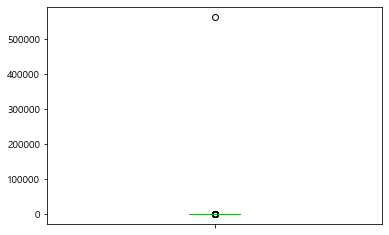

In [65]:
# 기업별 매출성장률 중 표준편차가 매우 큰, 변동성이 매우 큰 기업이 하나 있다.
GR.std().plot.box()
plt.show()

,corp_code,corp_name,stock_code
94805,00652159,코오롱머티리얼,144620


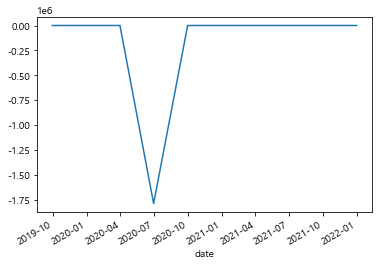

In [66]:
# 변동이 큰 회사는 코오롱머티리얼이며 2020년 2분기에 성장률이 급감한 것을 알 수 있다.
# 화학섬유 제조사인 코오롱머티리얼은 신흥국가의 저가공세와 아웃도어 시장의 장기적 정체로 적자를 보이다 2021년 12월 31일부로 거래를 종료했다.
display(corporation.query('corp_code == @GR.std().idxmax()'))
GR[GR.std().idxmax()].plot()
plt.show()

In [111]:
# 코오롱머티리얼 외의 기업 중 성장률이 높은 20개 기업과 변동은 적은 기업 20개에 모두 속하는 기업들의 성장률을 그래프로 출력한다.
good_GR = set(GR[[i for i in GR.columns if i != GR.std().idxmax()]].mean().sort_values(ascending=False).index[:20]) \
          & set(GR[[i for i in GR.columns if i != GR.std().idxmax()]].std().sort_values(ascending=True).index[:20])

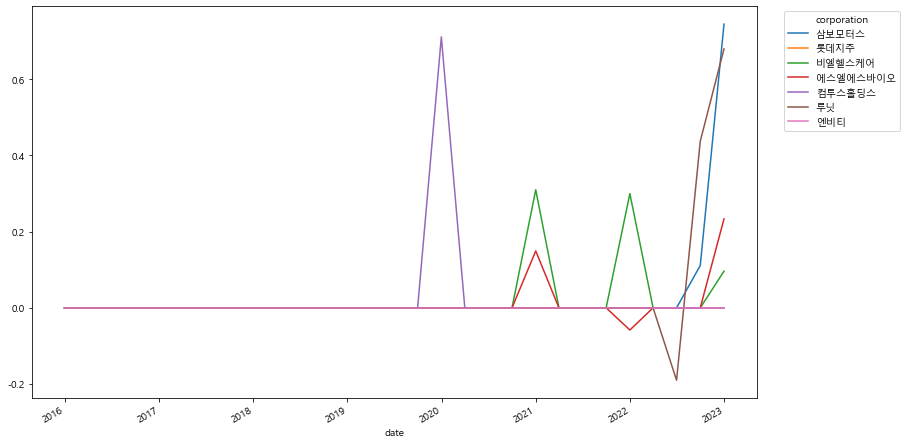

In [112]:
# 급성장 중인 삼보모터스와 투닛이란 기업을 확인할 수 있다.
top = GR[list(good_GR)].fillna(0)
top.columns = [corporation.query('corp_code==@i')['corp_name'].values[0] for i in top.columns]
top.plot(figsize=(13,8))
plt.legend(title='corporation', bbox_to_anchor=(1.03,1))
plt.show()

### 순이익 성장률

In [114]:
data['ProfitLoss_Rate'] = (data.groupby('corp_code')['ProfitLoss'].diff() / data['ProfitLoss']).fillna(0)
PR = pd.pivot_table(data.reset_index(), index='date', columns='corp_code', values='ProfitLoss_Rate')
PR

corp_code,00100601,00100939,00101257,00101664,00103015,00103547,00104120,00104388,00105271,00105606,...,01494154,01506990,01508855,01515323,01524118,01534577,01568875,01573381,01576102,01658266
date,,,,,,,,,,,,,,,,,,,,,
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-31,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-31,NaN,NaN,NaN,NaN,NaN,1.041866,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-31,NaN,NaN,NaN,NaN,NaN,0.255965,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-30,0.000000,0.000000,0.000000,0.000000,0.000000,22.890509,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-31,0.737116,3.650333,0.770911,0.369428,1.091941,1.021524,0.728080,-0.204082,0.549923,0.983460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-31,-24.791188,1.228966,-2.171317,-1.634904,-5.518175,-47.332717,-0.343746,-4.152027,0.609157,1.783746,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


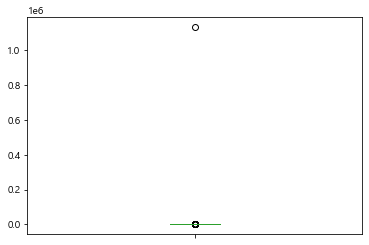

In [115]:
# 기업별 매출성장률 중 표준편차가 매우 큰, 변동성이 매우 큰 기업이 하나 있다.
PR.std().plot.box()
plt.show()

,corp_code,corp_name,stock_code
94805,00652159,코오롱머티리얼,144620


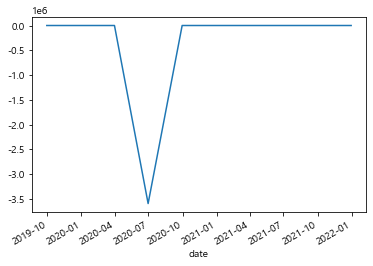

In [116]:
# 당기순이익 성장률 변동이 큰 회사도 코오롱머티리얼이다.
display(corporation.query('corp_code == @PR.std().idxmax()'))
PR[PR.std().idxmax()].plot()
plt.show()

In [126]:
# 코오롱머티리얼 외의 기업 중 성장률이 높은 20개 기업과 변동은 적은 기업 20개에 모두 속하는 기업은 없다.
set(PR[[i for i in PR.columns if i != PR.std().idxmax()]].mean().sort_values(ascending=False).index[:20]) \
& set(PR[[i for i in PR.columns if i != PR.std().idxmax()]].std().sort_values(ascending=True).index[:20])

set()

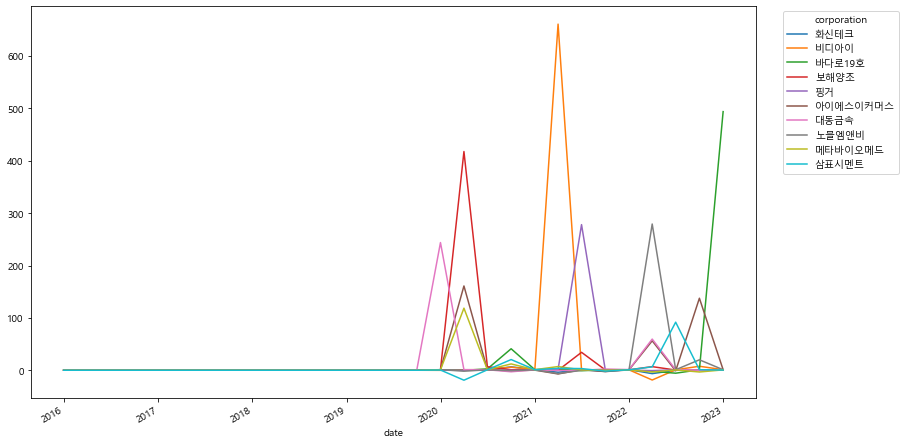

In [127]:
# 성장률이 높은 기업 10개의 성장률을 그려본다.
# 매출 성장률이 높은 기업 중 당기순이익 성장률이 높은 기업은 없다.
good_PR = PR[[i for i in PR.columns if i != PR.std().idxmax()]].mean().sort_values(ascending=False).index[:10]
top = PR[list(good_PR)].fillna(0)
top.columns = [corporation.query('corp_code==@i')['corp_name'].values[0] for i in top.columns]
top.plot(figsize=(13,8))
plt.legend(title='corporation', bbox_to_anchor=(1.03,1))
plt.show()

### EPS 성장률

In [129]:
data['EPS_Rate'] = (data.groupby('corp_code')['EPS'].diff() / data['EPS']).fillna(0)
ER = pd.pivot_table(data.reset_index(), index='date', columns='corp_code', values='EPS_Rate')
ER

corp_code,00100601,00100939,00101257,00101664,00103015,00103547,00104120,00104388,00105271,00105606,...,01494154,01506990,01508855,01515323,01524118,01534577,01568875,01573381,01576102,01658266
date,,,,,,,,,,,,,,,,,,,,,
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-31,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-31,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-31,NaN,NaN,NaN,NaN,NaN,-0.025352,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-31,0.734183,5.965116,0.899736,0.723982,1.170868,0.000000,0.823529,0.693878,0.0,0.987654,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-31,-28.013699,1.228117,0.000000,-1.630952,-5.490909,0.000000,-0.342105,-4.143646,0.0,1.900000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


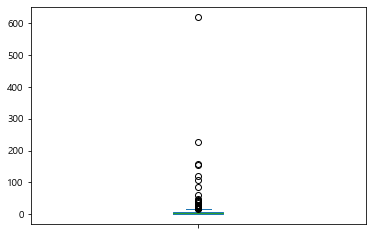

In [130]:
# 기업별 매출성장률 중 표준편차가 큰 10개 기업을 알아본다.
ER.std().plot.box()
plt.show()

,corp_code,corp_name,stock_code
88456,00124090,한국특강,007280
88851,00458234,아시아나IDT,267850
88858,01576102,미래에셋글로벌리츠,396690
89161,00120526,롯데쇼핑,023530
89433,00123541,보해양조,000890
90270,00536329,노블엠앤비,106520
90747,00349060,한스바이오메드,042520
92719,00606664,케이엔더블유,105330
93684,00191287,대동금속,020400
94897,00610490,비디아이,148140


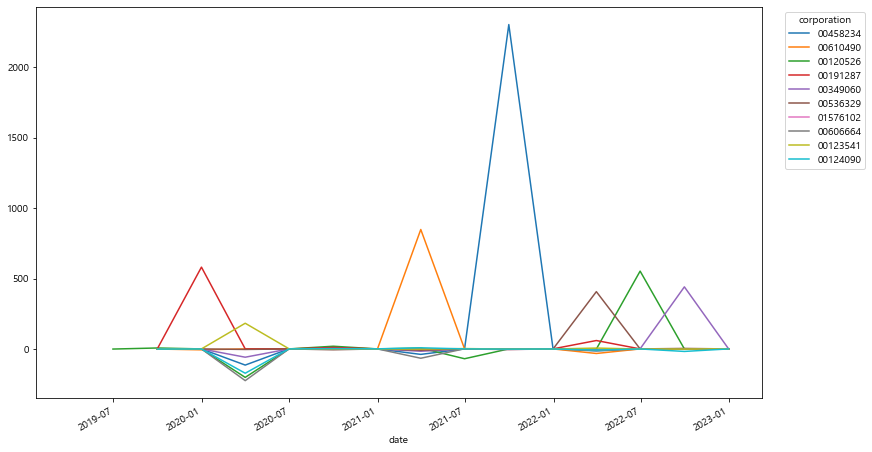

In [150]:
high_std = ER[ER.std().sort_values(ascending=False).index[:10]]
display(corporation.query('corp_code in @high_std'))

high_std.plot(figsize=(13,8))
plt.legend(title='corporation', bbox_to_anchor=(1.15,1))
plt.show()

In [148]:
# 성장률이 높은 20개 기업과 변동은 적은 기업 20개에 모두 속하는 기업은 없다.
set(ER[[i for i in ER.columns if i != ER.std().idxmax()]].mean().sort_values(ascending=False).index[:20]) \
& set(ER[[i for i in ER.columns if i != ER.std().idxmax()]].std().sort_values(ascending=True).index[:20])

set()

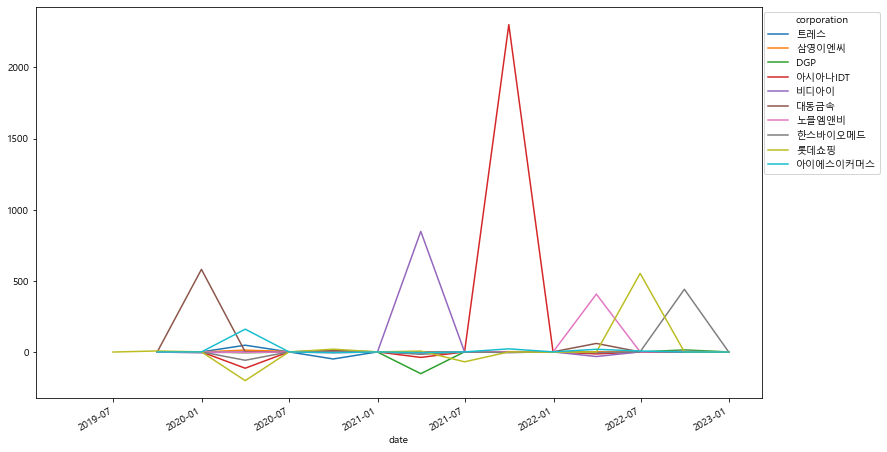

In [154]:
# 성장률이 높은 기업 10개의 성장률을 그려본다.
# 당기순이익 성장률이 높았던 기업 중 비디아이, 대동금속, 노블엠앤비, 아이에스이커머스, 삼표시멘트는 EPS 성장률도 높은 것으로 나타났다.
top = ER[ER.mean().sort_values(ascending=False).index[:10]]
top.columns = [corporation.query('corp_code==@i')['corp_name'].values[0] for i in top.columns]
top.plot(figsize=(13,8))
plt.legend(title='corporation', bbox_to_anchor=(1.17,1))
plt.show()